In [1]:
#from load import *
%load_ext autoreload
%autoreload 2
import pickle
from chainer.datasets import TupleDataset
from chainer.dataset import concat_examples
from chainer import functions as F, cuda
from chainer import iterators as I
from chainer import links as L
from chainer import optimizers as O
from chainer import training
from ipywidgets import interact
import chainer
import cupy
from tqdm import tqdm_notebook as tqdm
from chainer import serializers


from chainer_chemistry.datasets import NumpyTupleDataset
from chainer_chemistry.dataset.converters import concat_mols

import numpy
import numpy as np

from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import Draw
from rdkit import rdBase

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))))
from saliency.calculator.gradient_calculator import GradientCalculator
from models import predictor

sys.path.append(os.path.dirname(os.path.abspath('__file__')))
import data
from data import PYRIDINE_SMILES

In [3]:
import logging

# Disable errors by RDKit occurred in preprocessing Tox21 dataset.
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# show INFO level log from chainer chemistry
logging.basicConfig(level=logging.INFO)


In [4]:
import json

# training result directory
dirpath = './results/ggnndrop_pyridine'

json_path = os.path.join(dirpath, 'args.json')
if not os.path.exists(json_path):
    raise ValueError(
        'json_path {} not found! Execute train_tox21.py beforehand.'.format(json_path))
with open(json_path, 'r') as f:
    train_args = json.load(f)

method = train_args['method']
labels = train_args['label']  # 'pyridine'

unit_num = train_args['unit_num']
conv_layers = train_args['conv_layers']
class_num = 1
n_layers = train_args['n_layers']
dropout_ratio = train_args['dropout_ratio']
num_train = train_args['num_train']

model_path = os.path.join(dirpath, 'predictor.npz')


In [5]:
# Pyridine Dataset preparation
train, val, test, train_smiles, val_smiles, test_smiles = data.load_dataset(method, labels)
val_mols = [Chem.MolFromSmiles(smi) for smi in tqdm(val_smiles)]


load from cache input/ggnn_pyridine



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [6]:
target_dataset = val
target_smiles = val_smiles

In [7]:
target_dataset = val
target_smiles = val_smiles

#dataset_mols = [Chem.MolFromSmiles(smi) for smi in tqdm(train_smiles)]
#dataset_mols = [Chem.MolFromSmiles(smi) for smi in tqdm(val_smiles)]
val_mols = [Chem.MolFromSmiles(smi) for smi in tqdm(val_smiles)]

pi = Chem.MolFromSmarts(PYRIDINE_SMILES)
piindex = np.where(np.array([mol.HasSubstructMatch(pi) for mol in val_mols]) == True)
haspi = np.array(val_mols)[piindex]
haspiindex = [set(mol.GetSubstructMatch(pi)) for mol in haspi]

print('piindex', piindex)
print('haspi', haspi.shape)
print('haspiindex', haspiindex)

pyrigine_dataset = NumpyTupleDataset(*target_dataset.features[piindex, :])
pyrigine_smiles = target_smiles[piindex]

atoms = pyrigine_dataset.features[:, 0]
num_atoms = [len(a) for a in atoms]



piindex (array([  2,  18,  35,  43,  46,  59,  67,  79,  88,  98, 137, 145, 165,
       172, 178, 199, 202, 208, 222, 252, 253, 255, 266, 268, 278, 285,
       286, 294]),)
haspi (28,)
haspiindex [{5, 6, 7, 8, 10, 19}, {11, 12, 13, 14, 15, 16}, {4, 5, 6, 7, 8, 9}, {3, 4, 5, 7, 12, 13}, {16, 17, 18, 19, 20, 21}, {11, 12, 13, 14, 15, 16}, {16, 17, 18, 19, 20, 21}, {8, 9, 10, 17, 18, 23}, {3, 4, 5, 7, 8, 12}, {8, 9, 10, 11, 12, 13}, {1, 2, 3, 4, 6, 15}, {3, 4, 5, 27, 28, 29}, {10, 11, 12, 13, 14, 15}, {12, 13, 14, 15, 24, 25}, {4, 5, 6, 7, 8, 9}, {14, 15, 16, 23, 24, 25}, {12, 13, 14, 15, 16, 17}, {1, 2, 3, 34, 37, 27}, {2, 3, 4, 5, 20, 21}, {3, 4, 13, 14, 15, 16}, {14, 15, 16, 17, 18, 19}, {3, 4, 5, 6, 8, 10}, {2, 3, 4, 5, 6, 7}, {1, 2, 3, 4, 5, 6}, {18, 19, 20, 21, 22, 23}, {18, 19, 20, 21, 22, 23}, {6, 7, 14, 15, 18, 24}, {1, 2, 3, 15, 22, 25}]


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [8]:
# --- model preparation ---

model = predictor.build_predictor(
    method, unit_num, conv_layers, class_num, dropout_ratio, n_layers)

classifier = L.Classifier(model,
                          lossfun=F.sigmoid_cross_entropy,
                          accfun=F.binary_accuracy)

serializers.load_npz(model_path, model)

dropout_ratio, n_layers 0.25 1
Use GGNNDrop predictor...


In [9]:
def clip_original_size(saliency, num_atoms):
    """`saliency` array is 0 padded, this method align to have original
    molecule's length
    """
    assert len(saliency) == len(num_atoms)
    saliency_list = []
    for i in range(len(saliency)):
        saliency_list.append(saliency[i, :num_atoms[i]])
    return saliency_list

def preprocess_fun(*inputs):
    atom, adj, t = inputs
    # HACKING for now...
    # classifier.predictor.pick = True
    # result = classifier.predictor(atom, adj)
    atom_embed = classifier.predictor.graph_conv.embed(atom)
    return atom_embed, adj, t

def eval_fun(*inputs):
    atom_embed, adj, t = inputs
    prob = classifier.predictor(atom_embed, adj)
    # print('embed', atom_embed.shape, 'prob', prob.shape)
    # import IPython; IPython.embed()
    out = F.sum(prob)
    # return {'embed': atom_embed, 'out': out}
    return out


## Saliency calculation & visualization

You can calculate saliency and visualize it in following steps:

1. Instantiate Saliency Calculator
2. `compute_xxx` (xxx is vanilla/smooth/bayes) method to calculate saliency (gradient etc)
3. `transform` method to convert saliency into visualizable format.
4. Use Visualizer class to visualize it.

In [10]:
# 1. instantiation
gradient_calculator = GradientCalculator(
    classifier, eval_fun=eval_fun,
    # target_key='embed', eval_key='out',
    target_key=0,
)

In [11]:
M = 40
rates = np.array(list(range(1, 11))) * 0.1

# --- VanillaGrad ---
# 2. compute
saliency_arrays_vanilla = gradient_calculator.compute_vanilla(
    pyrigine_dataset, converter=concat_mols, preprocess_fn=preprocess_fun)
# 3. transform
saliency_vanilla = gradient_calculator.transform(
    saliency_arrays_vanilla, ch_axis=3, method='square')
# saliency_arrays (1, 28, 43, 64) -> M, minibatch, max_atom, ch_dim
print('saliency_arrays', saliency_arrays_vanilla.shape)
# saliency (28, 43) -> minibatch, max_atom
print('saliency', saliency_vanilla.shape)

saliency_arrays (1, 28, 43, 16)
saliency (28, 43)


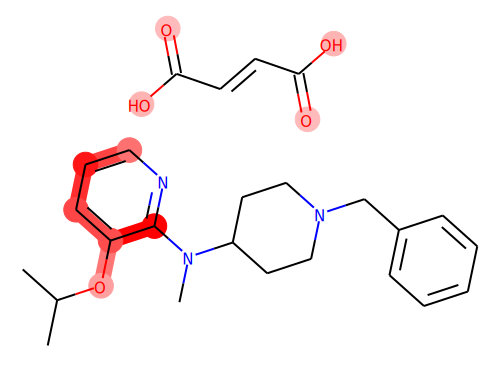

In [12]:
from saliency.visualizer.smiles_visualizer import SmilesVisualizer

sv = SmilesVisualizer()
# 4. visualize
index = 2
sv.visualize(saliency_vanilla[index], pyrigine_smiles[index], visualize_ratio=0.3)

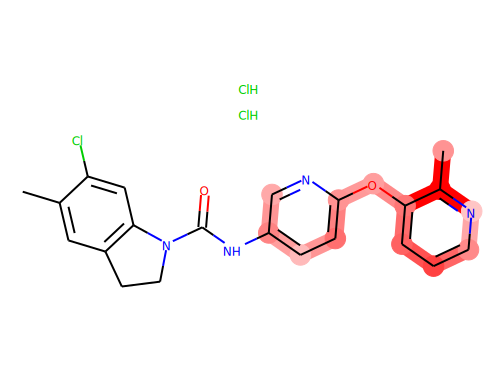

<function __main__.sv_visualize>

In [13]:
# interactive plot demo

def sv_visualize(i, ratio):
    return sv.visualize(saliency_vanilla[i], pyrigine_smiles[i], visualize_ratio=ratio)

interact(sv_visualize, i=(0, len(saliency_vanilla) - 1, 1), ratio=(0, 1.0, 0.1))

In [14]:
# --- SmoothGrad ---
saliency_arrays_smooth = gradient_calculator.compute_smooth(
    pyrigine_dataset, converter=concat_mols, preprocess_fn=preprocess_fun,
    M=M, mode='absolute', scale=0.1)

In [15]:
# --- BayesGrad ---
# `train=True` enables dropout, which corresponds to BayesGrad
saliency_arrays_bayes = gradient_calculator.compute_vanilla(
    pyrigine_dataset, converter=concat_mols, preprocess_fn=preprocess_fun,
    M=M, train=True)

In [24]:
# Multiple plot demo
from IPython.display import display, HTML

def sv_visualize(i, ratio, lam, method, view):
    saliency_vanilla = gradient_calculator.transform(
        saliency_arrays_vanilla, ch_axis=3, method=method, lam=0)
    saliency_smooth = gradient_calculator.transform(
        saliency_arrays_smooth, ch_axis=3, method=method, lam=lam)
    saliency_bayes = gradient_calculator.transform(
        saliency_arrays_bayes, ch_axis=3, method=method, lam=lam)
    
    if view == 'view':
        svg_vanilla = sv.visualize(saliency_vanilla[i], pyrigine_smiles[i], visualize_ratio=ratio)
        svg_smooth = sv.visualize(saliency_smooth[i], pyrigine_smiles[i], visualize_ratio=ratio)
        svg_bayes = sv.visualize(saliency_bayes[i], pyrigine_smiles[i], visualize_ratio=ratio)
        display(svg_vanilla, svg_smooth, svg_bayes)
    elif view == 'save':
        os.makedirs('results/visualize/pyridine', exist_ok=True)
        sv.visualize(saliency_vanilla[i], pyrigine_smiles[i], visualize_ratio=ratio, save_filepath='results/visualize/pyridine/{}_vanilla.png'.format(i))
        sv.visualize(saliency_smooth[i], pyrigine_smiles[i], visualize_ratio=ratio, save_filepath='results/visualize/pyridine/{}_smooth.png'.format(i))
        sv.visualize(saliency_bayes[i], pyrigine_smiles[i], visualize_ratio=ratio, save_filepath='results/visualize/pyridine/{}_bayes.png'.format(i))
    else:
        print(view, 'not supported')

interact(sv_visualize, i=(0, len(saliency_vanilla) - 1, 1), ratio=(0, 1.0, 0.1), lam=(-3.0, 3.1, 0.1), method=['square', 'abs', 'raw'], view=['view', 'save'])

saving png to results/visualize/pyridine/10_vanilla.png
saving png to results/visualize/pyridine/10_smooth.png
saving png to results/visualize/pyridine/10_bayes.png


In [17]:
i = 0
mol = Chem.MolFromSmiles(pyrigine_smiles[i])
mol.GetNumAtoms()

27

## Appendix: GetSubstructMatch & GetSubstructMatches comparison


 - GetSubstructMatch only extracts one substructure.
 - GetSubstructMatches extracts all substructure.

In [18]:

#Draw.MolToFile(mol, 'comp.png', highlightAtoms=match_list)


i = 12

mol = Chem.MolFromSmiles(pyrigine_smiles[i])

py = Chem.MolFromSmarts(PYRIDINE_SMILES)
py_match = mol.GetSubstructMatch(py)
py_matches = mol.GetSubstructMatches(py)


In [19]:
print('py_match', type(py_match), py_match, set(py_match))
print('py_matches', type(py_matches), py_matches)

py_match <class 'tuple'> (11, 10, 15, 14, 13, 12) {10, 11, 12, 13, 14, 15}
py_matches <class 'tuple'> ((11, 10, 15, 14, 13, 12), (23, 22, 27, 26, 25, 24))


In [20]:
def flatten_tuple(x):
    return [element for tupl in x for element in tupl]

py_indices = flatten_tuple(py_matches)
print(py_indices)

[11, 10, 15, 14, 13, 12, 23, 22, 27, 26, 25, 24]


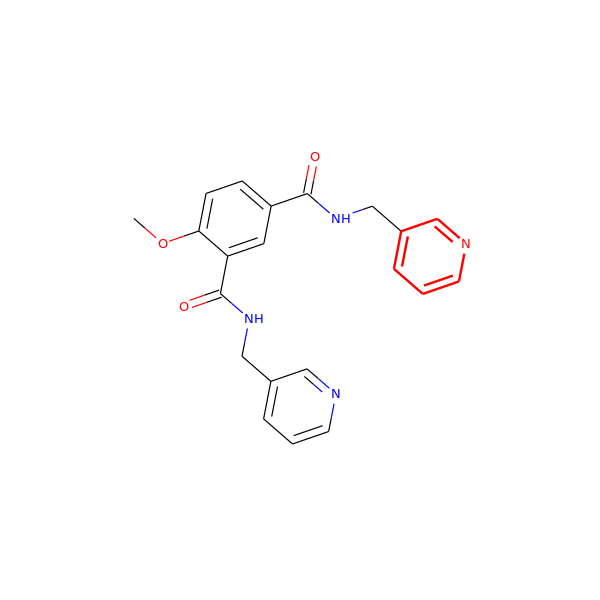

In [21]:
Chem.SanitizeMol(mol)
Draw.MolToImage(mol, size=(600, 600), highlightAtoms=set(py_match))


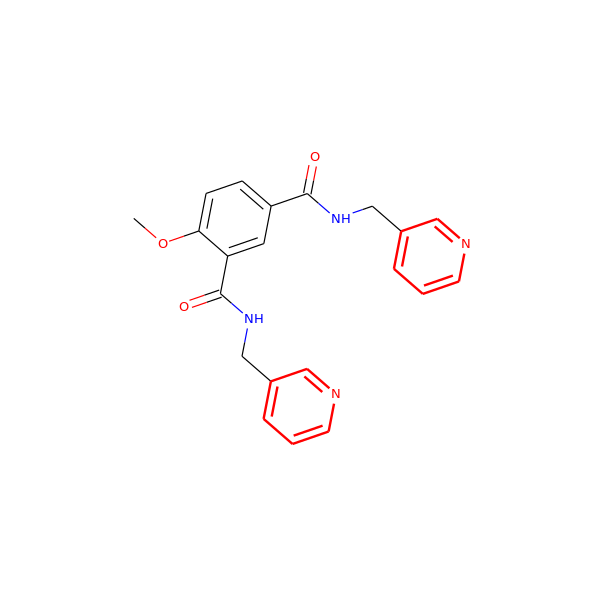

In [22]:
Chem.SanitizeMol(mol)
Draw.MolToImage(mol, size=(600, 600), highlightAtoms=py_indices)


In [23]:
print(len(pyrigine_smiles), len(haspiindex))

28 28
